# Thompson Sampling on Bernoulli

## Import required libraries

In [1]:
import numpy as np
import matplotlib.pyplot as plt

from scipy.stats import beta

## Set hyperparameters

In [2]:
NUM_OF_BANDITS = 10
NUM_OF_TRIALS = 5000

# Variables to count regret metrics
total_rewards = 0

## Create our bandit model

Our bandit model will have the following variables:
* result = Used to track all the result after pulling the bandit's arm, will be used only for logging purposes.
* probability = The probability of giving the success reward (value = 1)
* alpha = total amount of FAILURE (0) from pulling the bandit arm
* beta = total amount of SUCCESS (1) from pulling the bandit arm

In [3]:
class TS_Bandit:
    def __init__(self, probability):
        # For log purposes
        self.result = []
        
        # latent variables
        self.probability = probability
        
        # Bandit will have the property of beta distribution as the conjugate prior of the bernoulli distribution
        # Alpha and Beta is set to 0.04 by default to prevent error when sampling, it needs to be a very small number
        self.alpha = 0.04
        self.beta = 0.04
    
    def update_posterior(self, reward):
        if reward:
            self.alpha += 1          # Reward = 1 or TRUE, alpha add one success
        else:
            self.beta += 1           # Reward = 0 or FALSE, beta add one failure
    
    def pull_bandit_arm(self):
        # Generate random bernoulli as reward
        # parameter:
        # p = success probability
        # f(x) = p^x * (1-p)^1-x
        reward = np.random.binomial(n=1, p=self.probability, size=None)
        
        # self.update_posterior(reward)

        self.result.append(reward)
        
        return reward
        

`update_posterior(reward)` function is used to update the knowledge after pulling a bandit. The function will increment the value of alpha or beta depends on the reward when pulling.

`pull_bandit_arm()` will generate random reward either 0 or 1 (bernoulli), after that it will automatically update the posterior and return a reward.

In [4]:
def sample_reward_probability(bandit_list):
    return [np.random.beta(bandit.alpha, bandit.beta) for bandit in bandit_list]

`sample_reward_probability(bandit_list)` will get all the bandit model, and for each bandit, it will draw sample from a beta distribution.

## Generate number of bandit with random discrete probability (bernoulli)

In [5]:
bandit_list = []

for i in range(NUM_OF_BANDITS):
    bandit_list.append(TS_Bandit(np.random.rand()))

print(f'{NUM_OF_BANDITS} random bandits successfully generated with random probability!')

10 random bandits successfully generated with random probability!


In [6]:
# # Hardcoded (DEBUG Only)
# bandit_list = [
#     TS_Bandit(0.5),
#     TS_Bandit(0.6),
#     TS_Bandit(0.7),
#     TS_Bandit(0.8),
#     TS_Bandit(0.85)
# ]

## Thompson Sampling Step-bystep

We successfully set the whole thing up, now it's time to explore and exploit with the thompson sampling.

## 1. Take a random sample from all bandits

The sampled reward will basically just be a random number, because the alpha and beta (prior knowledge) from all bandits is currently 1, indicating that our agent have no idea about which bandit will return the best possible reward

In [7]:
sampled_reward = sample_reward_probability(bandit_list)
print(sampled_reward)

[1.0, 6.671241477464992e-12, 5.0081869496011545e-14, 0.0002311180330108508, 0.999999999999958, 1.0, 1.1089419685815452e-06, 0.9936019030948796, 1.0, 0.00019538484739903972]


## 2. Pick a best arm based on the sampled beta distribution

In [8]:
bandit_choice = np.argmax(sampled_reward)
print(f'Best bandit sample index: {bandit_choice}')

Best bandit sample index: 0


We sampled random number using the beta distribution of each bandit. From the result, we must take the maximum value of the sample and use it as the choice of bandit we are going to pull (best arm).

## 3. Pull the best bandit arm and observe the reward

In [9]:
# Pull best bandit arm
reward = bandit_list[bandit_choice].pull_bandit_arm()
print(f'Rolled the bandit index-{bandit_choice} and get the reward: {reward}')

Rolled the bandit index-0 and get the reward: 0


## 4. Update the corresponding bandit posterior distribution

In [10]:
# Update the knowledge of the bandit
bandit_list[bandit_choice].update_posterior(reward)
print(f'Updated the bandit posterior distribution')

Updated the bandit posterior distribution


Now That's one iteration of how thompson sampling works. Repeat this time until we reach the `NUM_OF_TRIALS`.

## 5. Iterate until the `NUM_OF_TRIALS`

In [11]:
for i in range(NUM_OF_TRIALS):
    
    # 1. Sample Reward
    sampled_reward = sample_reward_probability(bandit_list)

    # 2. Pick the best arm
    bandit_choice = np.argmax(sampled_reward)

    # 3. Pull the corresponding bandit
    reward = bandit_list[bandit_choice].pull_bandit_arm()

    # 4. Update Posterior
    bandit_list[bandit_choice].update_posterior(reward)

## Let's inspect which bandit have the best overall reward after all iterations

In [12]:
for i,bandit in enumerate(bandit_list):
    print(f'Bandit index-{i}')
    print(f'number of picked: {bandit.alpha + bandit.beta - 0.8}')     # -2 the initial alpha and beta
    
    # print(f'{bandit.result}')
    
    print(f'alpha beta = {bandit.alpha-0.04} - {bandit.beta-0.04}')

    print(f'observed probability: {round(bandit.alpha / (bandit.alpha + bandit.beta) * 100,2)}%')
    
    print('==============================')

Bandit index-0
number of picked: 1.28
alpha beta = 0.0 - 2.0
observed probability: 1.92%
Bandit index-1
number of picked: 7.28
alpha beta = 4.0 - 4.0
observed probability: 50.0%
Bandit index-2
number of picked: 4961.28
alpha beta = 4769.0 - 193.0
observed probability: 96.11%
Bandit index-3
number of picked: 1.28
alpha beta = 0.0 - 2.0
observed probability: 1.92%
Bandit index-4
number of picked: 1.28
alpha beta = 0.0 - 2.0
observed probability: 1.92%
Bandit index-5
number of picked: 9.28
alpha beta = 6.0 - 4.0
observed probability: 59.92%
Bandit index-6
number of picked: 5.28
alpha beta = 2.0 - 4.0
observed probability: 33.55%
Bandit index-7
number of picked: 1.28
alpha beta = 0.0 - 2.0
observed probability: 1.92%
Bandit index-8
number of picked: 4.28
alpha beta = 2.0 - 3.0
observed probability: 40.16%
Bandit index-9
number of picked: 1.28
alpha beta = 0.0 - 2.0
observed probability: 1.92%


**Thompson sampling seems to have a high capabilities in exploiting the best arm in such a short time**, we can tell that this algorithm is one of the best choice to actually be tested on real life cases. Despite this finding, Thompson Sampling also have weaknesses. **Thompson sampling bandit is not good at observing each of the bandit arm**, as the number of observations on the un-exploited bandit is very low. But low success rate does not mean that thompson sampling is bad at exploration. We will see why.

> Notice that the observed probability for the bandit that is almost never got pulled is very unprecise. In fact, Thompson sampling does not have to give you the exact or at least really narrow probability range. The algorithm just need to understand which bandit tends to give more reward than the other and that is enough to exploit the whole system.

## Show the beta distribution graph for each bandit

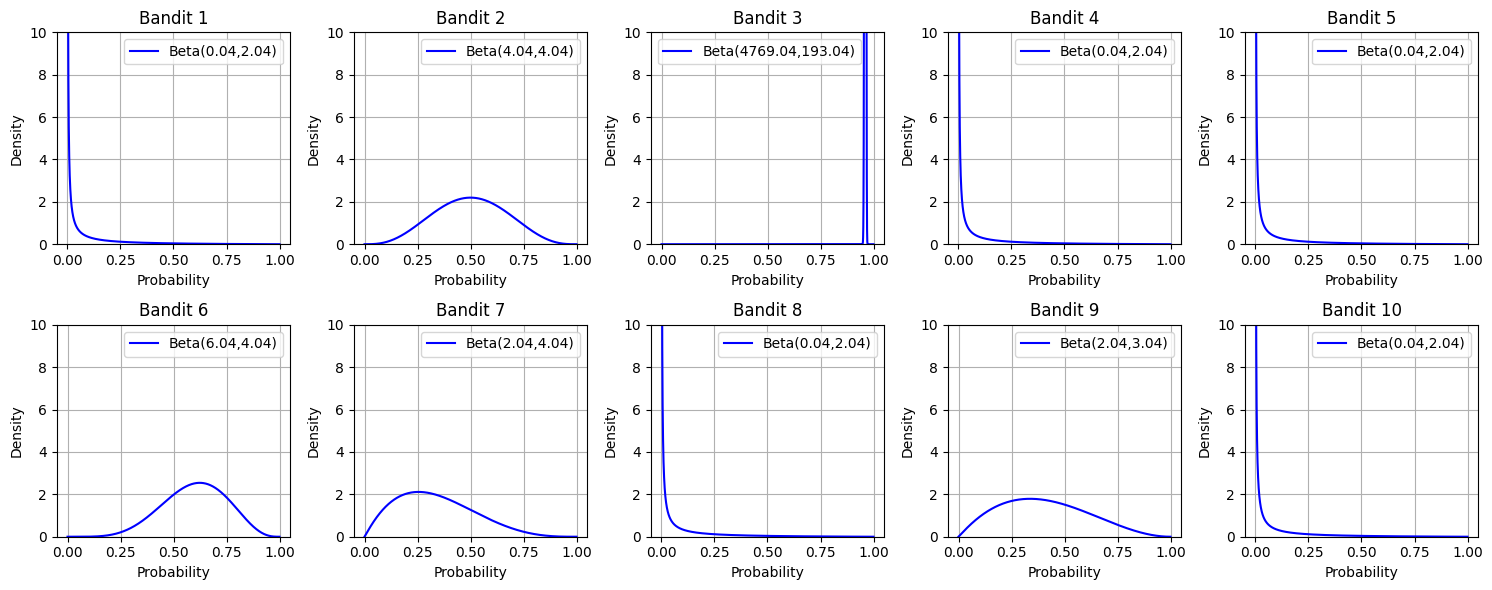

In [13]:
fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(15, 6))  # 2 rows, 5 columns for 10 bandits

axes = axes.flatten()  # Flatten the 2D axes array for iteration

for i, (bandit, ax) in enumerate(zip(bandit_list, axes)):
    x = np.linspace(0, 1, 10000)  # Range of x values
    y = beta.pdf(x, bandit.alpha, bandit.beta)  # Compute the Beta PDF

    ax.plot(x, y, 'b-', label=f'Beta({bandit.alpha},{bandit.beta})')
    ax.set_title(f'Bandit {i+1}')
    ax.set_xlabel('Probability')
    ax.set_ylabel('Density')
    ax.legend()
    ax.grid(True)
    ax.set_ylim(0, 10)

# Adjust layout for better spacing
plt.tight_layout()
plt.show()

By looking at the beta distribution graph, we can tell that the that graph that has the highest skewness is the best bandit.

We notice this by the number of times it gets pulled compared to the other, meaning that the bandit is very sure that this is the right bandit which will give the best expected reward. The skewness of the graph is also helpful as it opens up possibilities for the other bandit to overcome current best bandit because the range on the right and left side of the graph is still high enough.

## Let's just reveal the stats of each bandit actual probabilities and see if our agent had made the correct decision

In [17]:
for i,bandit in enumerate(bandit_list):
    print(f'Bandit index-{i}')
    print(f'number of picked: {int(bandit.alpha + bandit.beta - 0.08)}')     # -2 the initial alpha and beta
    
    # print(f'{bandit.result}')
    
    print(f'alpha beta = {int(bandit.alpha-0.04)} - {int(bandit.beta-0.04)}')

    print(f'observed probability: {round(bandit.alpha / (bandit.alpha + bandit.beta) * 100,2)}%')
    print(f'actual probability: {round(bandit.probability*100,2)}%')
    
    print('==============================')

Bandit index-0
number of picked: 2
alpha beta = 0 - 2
observed probability: 1.92%
actual probability: 15.7%
Bandit index-1
number of picked: 8
alpha beta = 4 - 4
observed probability: 50.0%
actual probability: 69.36%
Bandit index-2
number of picked: 4962
alpha beta = 4769 - 193
observed probability: 96.11%
actual probability: 96.25%
Bandit index-3
number of picked: 2
alpha beta = 0 - 2
observed probability: 1.92%
actual probability: 5.17%
Bandit index-4
number of picked: 2
alpha beta = 0 - 2
observed probability: 1.92%
actual probability: 71.79%
Bandit index-5
number of picked: 10
alpha beta = 6 - 4
observed probability: 59.92%
actual probability: 75.22%
Bandit index-6
number of picked: 6
alpha beta = 2 - 4
observed probability: 33.55%
actual probability: 59.27%
Bandit index-7
number of picked: 2
alpha beta = 0 - 2
observed probability: 1.92%
actual probability: 0.16%
Bandit index-8
number of picked: 5
alpha beta = 2 - 3
observed probability: 40.16%
actual probability: 31.03%
Bandit in